In [2]:
import pandas as pd
from collections import Counter
from scipy.stats import entropy
import re
import spacy
import matplotlib.pyplot as plt

In [3]:
ALL = False # true if i want all the books, false if i just want to focus on case studies 

In [4]:
if ALL: 
    DATA_SOURCE = "book_popularity.parquet"
else: 
    DATA_SOURCE = "case_studies.parquet"

In [5]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.add_pipe("sentencizer")
nlp.max_length = 2_000_000

In [6]:
df = pd.read_parquet(DATA_SOURCE)

df.head(5)

,title,text
0,murder_of_roger_ackroyd.txt,﻿The Project Gutenberg eBook of The murder of ...
1,infinite_jest.txt,INFINITE JEST\n\n\nby David Foster Wallace\n\n...
2,heated_rivalry.txt,\t\t\tHeated Rivalry\n\nBy Rachel Reid\n\n\t\t...
3,the_alchemist.txt,THE\n\nALCHEMIST\n\n\n\n\nPAULO COELHO\n\nTRAN...


In [7]:
from collections import Counter
from itertools import tee
from scipy.stats import entropy
import pandas as pd

# helper to generate bigrams
def get_bigrams(words):
    a, b = tee(words)
    next(b, None)
    return list(zip(a, b))

# calculate entropy from counts
def calculate_entropy(distribution):
    counts = Counter(distribution).values()
    total = sum(counts)
    probabilities = [c / total for c in counts]
    return entropy(probabilities, base=2)

def generate_stats(text, max_words=15000, use_sentences=False):
    sentences = text.split(". ")
    
    # grab last max_sentences or words
    if use_sentences:
        max_sentences = 500
        truncated = sentences[-max_sentences:]
        truncated_text = ". ".join(truncated)
    else: 
        truncated = []
        current_word_count = 0
        for sentence in reversed(sentences):
            sentence_word_count = len(sentence.split())
            if current_word_count + sentence_word_count > max_words:
                break
            truncated.append(sentence)
            current_word_count += sentence_word_count
        truncated = list(reversed(truncated))
        truncated_text = ". ".join(truncated)

    doc = nlp(truncated_text)

    sentence_lengths = []
    words = []
    pos_tags = []

    for sent in doc.sents:
        alpha_tokens = [t for t in sent if t.is_alpha]
        sentence_lengths.append(len(alpha_tokens))
        for token in alpha_tokens:
            words.append(token.text.lower())  # lowercase for consistency
            pos_tags.append(token.pos_)

    # unigrams
    words_entropy = calculate_entropy(words)
    sentences_entropy = calculate_entropy(sentence_lengths)
    pos_entropy = calculate_entropy(pos_tags)

    # bigrams
    bigrams = get_bigrams(words)
    bigram_entropy = calculate_entropy(bigrams)

    return pd.Series({
        'word_entropy': words_entropy,
        'bigram_entropy': bigram_entropy,
        'sentence_entropy': sentences_entropy,
        'pos_entropy': pos_entropy,
        'length': len(truncated_text)
    })

# Apply to your dataframe
df[['word_entropy', 'bigram_entropy', 'sentence_entropy', 'pos_entropy', 'length']] = \
    df["text"].apply(lambda x: generate_stats(x, use_sentences=True))

df.head(5)

,title,text,word_entropy,bigram_entropy,sentence_entropy,pos_entropy,length
0,murder_of_roger_ackroyd.txt,﻿The Project Gutenberg eBook of The murder of ...,8.779148,12.414579,5.160895,3.415818,68379.0
1,infinite_jest.txt,INFINITE JEST\n\n\nby David Foster Wallace\n\n...,9.591333,12.961962,5.324145,3.402296,72578.0
2,heated_rivalry.txt,\t\t\tHeated Rivalry\n\nBy Rachel Reid\n\n\t\t...,8.805585,12.439253,4.483240,3.462228,53922.0
3,the_alchemist.txt,THE\n\nALCHEMIST\n\n\n\n\nPAULO COELHO\n\nTRAN...,8.436252,12.258850,4.831652,3.349495,69593.0


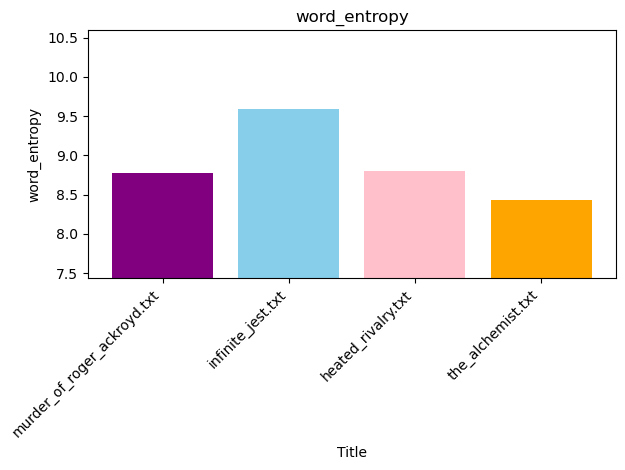

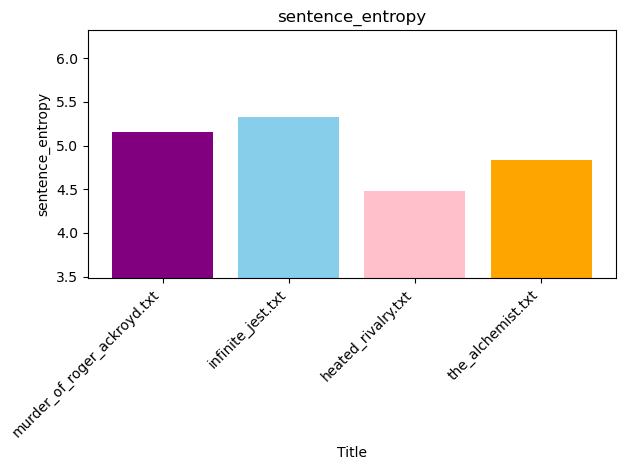

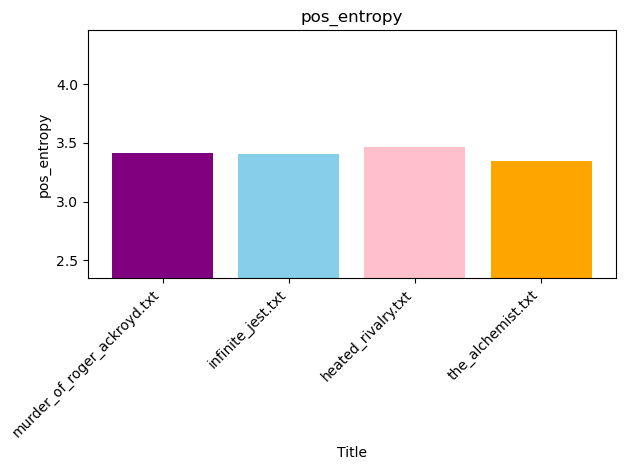

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def generate_plot(x, y, log=False, y_range=None, line_of_best_fit=True): 
    if ALL: 
        df_plot = df.copy()
        if y_range is not None:
            y_min, y_max = y_range
            df_plot = df_plot[(df_plot[y] >= y_min) & (df_plot[y] <= y_max)]

        plt.figure()
        plt.scatter(df_plot[x], df_plot[y])

        # add line of best fit
        if line_of_best_fit and len(df_plot) > 1:
            x_vals = df_plot[x].values
            y_vals = df_plot[y].values
            coeffs = np.polyfit(x_vals, y_vals, 1)
            fit_line = np.poly1d(coeffs)
            plt.plot(x_vals, fit_line(x_vals), color='red', linestyle='--', label='Best fit')
            plt.legend()

        if log: 
            plt.xscale("log")
            plt.xlabel(f"{x} (log)")
            plt.ylabel(y)
            plt.title(f"log version: {x} vs {y}")
        else: 
            plt.xlabel(x)
            plt.ylabel(y)
            plt.title(f"{x} vs {y}")

        if y_range is not None:
            plt.ylim(y_min, y_max)

        plt.show()
    else: 
        colors = ["purple", "skyblue", "pink", "orange"]

        plt.figure()
        plt.bar(df[x], df[y], color=colors)
        ymin = df[y].min()
        ymax = df[y].max()
        plt.ylim(ymin - 1, ymax + 1)
        plt.xlabel("Title")
        plt.ylabel(y)
        plt.title(y)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()




if ALL: 
    generate_plot("download_count", "word_entropy")
    generate_plot("download_count", "sentence_entropy")
    generate_plot("download_count", "pos_entropy")
    generate_plot("download_count", "bigram_entropy")


    generate_plot("download_count", "word_entropy", log=True)
    generate_plot("download_count", "sentence_entropy", log=True)
    generate_plot("download_count", "pos_entropy", log=True)
    generate_plot("download_count", "bigram_entropy", log=True)

else: 
    generate_plot("title", "word_entropy", line_of_best_fit=False)
    generate_plot("title", "sentence_entropy")
    generate_plot("title", "pos_entropy")



In [9]:
generate_plot("download_count", "word_entropy", log=True, y_range=(6, 12))
generate_plot("download_count", "sentence_entropy", log=True, y_range=(3, 7))
generate_plot("download_count", "pos_entropy", log=True, y_range=(1.5, 4))
generate_plot("download_count", "bigram_entropy", log=True, y_range=(10, 14))

KeyError: 'download_count'

<Figure size 640x480 with 0 Axes>